# Introduction
- このノートブックでは、MFCCについて学びます。
- ref: http://aidiary.hatenablog.com/entry/20120225/1330179868

# Let's import everything we need :)

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display
import scipy

# Data Preparation

In [13]:
filename = librosa.util.example_audio_file()
_data, sr = librosa.load(filename, sr=None)
n = 20
data = _data[1000*n:1000*n +40000]

# Exploratory Data Analysis

**basics**

In [14]:
print('n_samples:   ', len(data))
print('sample rate: ', sr)
print('length:       {:.1f} sec'.format(len(data)/sr))

n_samples:    40000
sample rate:  44100
length:       0.9 sec


---
**plot**

Text(0.5, 0, 'time(sec)')

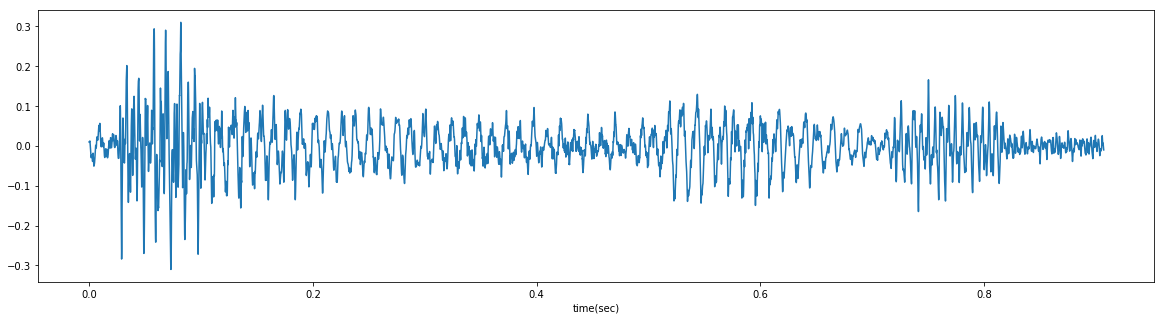

In [15]:
plt.figure(figsize=(20, 5))
_x = np.arange(0, len(data))/sr  # 横軸の単位を index から sec に
plt.plot(_x, data)
plt.xlabel('time(sec)')

---
**listen :)**

In [16]:
IPython.display.Audio(data, rate=sr)

# MFCC

- MFCC は音声解析や異音検知でよく使われる特徴量です。
- 以下の tutorial でMFCCの詳細について学びます。

## フーリエ変換をする前に、ハミング窓をかける

**窓の生成と適用**

In [17]:
HammingWindow = np.hamming(len(data))
data_hamm = data * HammingWindow

---
**plot**

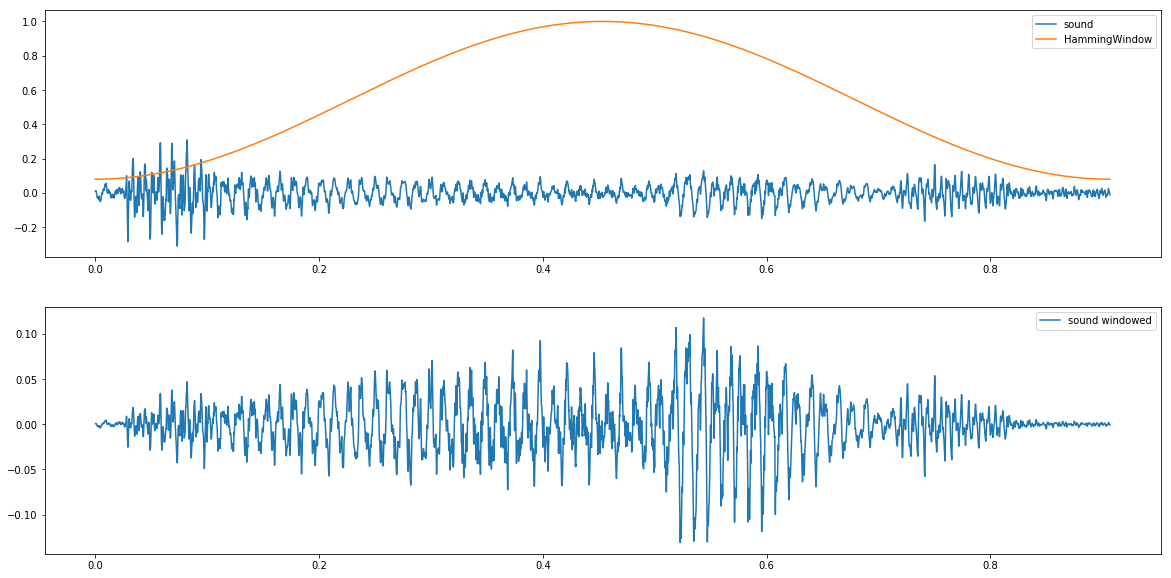

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs.ravel()
axs[0].plot(_x, data, label='sound')
axs[0].plot(_x, HammingWindow, label='HammingWindow')
axs[0].legend()
axs[1].plot(_x, data_hamm, label='sound windowed')
axs[1].legend()

## フーリエ変換

In [19]:
# ----- set params -----
nfft = sr # FFTのサンプル数
# ----------------------

---
**Do it**

In [20]:
spec = np.fft.fft(data_hamm, nfft)[:int(nfft/2)]  # 2で割っているのは、ナイキスト周波数を考慮したため
spec_abs = np.abs(spec)
fscale = np.fft.fftfreq(nfft, d=1.0/sr)[:int(nfft/2)]

---
**plot**

Text(0.5, 0, 'frequency [Hz]')

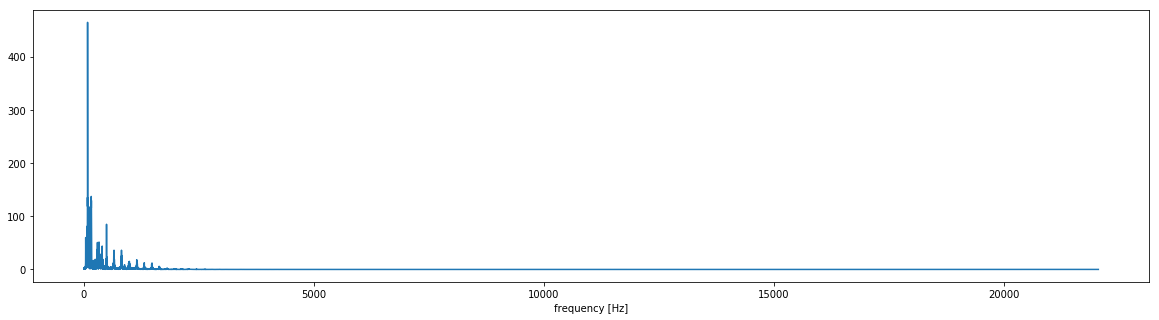

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(fscale, spec_abs)
ax.set_xlabel('frequency [Hz]')

## 人間に聞こえる音について
ある音(周波数$f_{0}$) を人間が聞いていたとします。この周波数を2倍、3倍と大きくしていくと、人間にはどう聞こえるでしょうか。   
答えは、`音の高さが2倍、3倍には聞こえない` です。一般に、人間が2倍3倍と感じるには、対数的に周波数が大きくなる必要があるようです。  
では、100Hzの音を聞いてもらった人にその2倍の周波数で聞こえる音というのはどの程度の周波数なのでしょうか。  
その疑問に答える概念が、メル周波数です。


### メル周波数
メル周波数と、周波数の関係は、以下のように表されます 。
$$
f_{mel} = 1127 \ln \left( \frac{f}{700} + 1 \right)
$$
ここで、$f_{mel}$、$f$の単位はそれぞれ、`mel`、`Hz` です。  
$f = 1000$ Hz のとき、$f_{mel} = 1000$ mel になるように調整されています。 
$f_{mel}$が2倍、3倍になったときに、人間は音の高さが2倍、3倍になったと感じます。  
グラフを書いてみます。

In [11]:
def hz2mel(f):
    """Hzをmelに変換"""
    return 1127.01048 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
    """melをhzに変換"""
    return 700.0 * (np.exp(m / 1127.01048) - 1.0)

---
**plot**

Text(0, 0.5, 'mel')

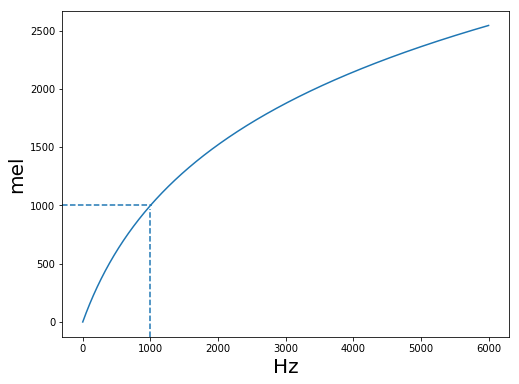

In [12]:
hzs = np.arange(0, 6000, 0.1)
_y = [hz2mel(hz) for hz in hzs]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hzs, _y)
ax.axvline(x=1000, ymin=0, ymax=1000/max(_y),  linestyle='--')
ax.axhline(y=1000, xmin=0, xmax=1200/max(hzs), linestyle='--')
ax.set_xlabel('Hz', fontsize=20)
ax.set_ylabel('mel', fontsize=20)

## 対数スペクトル
- 続いて、対数スペクトルを見てみたいと思います。
- 先程のフーリエ変換したデータの対数を取ります。

**plot**

Text(0.5, 0, 'Hz')

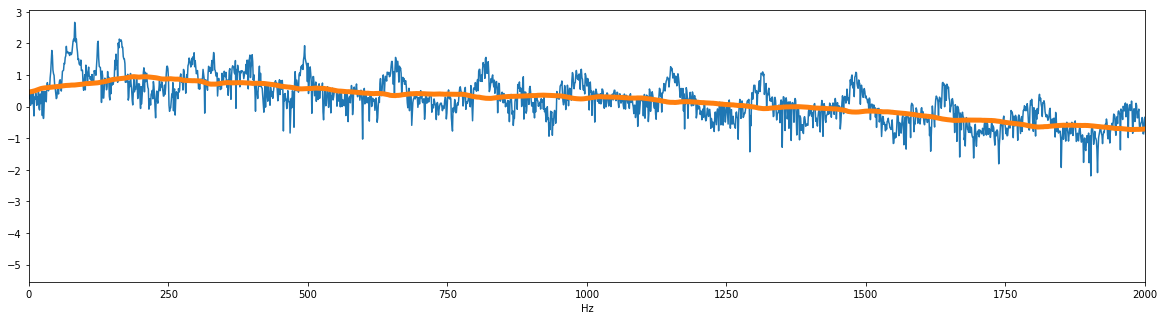

In [23]:
spec_ebs_log = np.log10(spec_abs)

#移動平均
num = 300
b=np.ones(num)/num
spec_ebs_log_ave=np.convolve(spec_ebs_log, b, mode='same')#移動平均

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(fscale, spec_ebs_log)
ax.plot(fscale, spec_ebs_log_ave, lw=5)
ax.set_xlim(0, 2000)
ax.set_xlabel('Hz')

対数を取ることで、強度の小さかった高周波側も強調されて表示されているのがわかると思います。  
このとき上図のオレンジ色の包絡線を`声道特性`と呼びます。  
音声認識技術において、この声道特性はとても重要な意味を持ちます。  
話している人の違い、'あ'と'い'の発音の違いはこの包絡線に現れます。  
MFCCは、この包絡線の違いを捉えている特徴量です。  
では、どのようにこの包絡線を捉えればいいでしょうか。  
簡単なアイデアとしては、上図のスペクトルをフーリエ変換(周波数空間-->時間空間)し、小さい時間成分を取り出すというのが、考えられます。(ケプストラム解析と呼ばれます。)

## メルフィルタバンク
- 前節で解説したmel周波数を参考に、メルフィルタバンクというものを作成します。
- メルフィルタバンクとは、メル尺度上で等間隔になるように配置されたバンドパスフィルタ群です。
- 順番に解説していきます。まずは、プロットしてみます。

In [14]:
nmax = 11025.0

In [15]:
def melFilterBank(fs, nfft, numChannels):
    """メルフィルタバンクを作成"""
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = nfft / 2
    df = fs / nfft
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    fcenters = mel2hz(melcenters)
    indexcenter = np.round(fcenters / df)
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))

    filterbank = np.zeros((numChannels, int(nmax)))
    for c in np.arange(0, numChannels):
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            i = int(i)
            filterbank[c, i] = (i - indexstart[c]) * increment
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            i = int(i)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

# メルフィルタバンクを作成
numChannels = 20  # メルフィルタバンクのチャネル数
df = sr / nfft   # 周波数解像度（周波数インデックス1あたりのHz幅）
filterbank, fcenters = melFilterBank(sr, nfft, numChannels)

Text(0.5, 0, 'Hz')

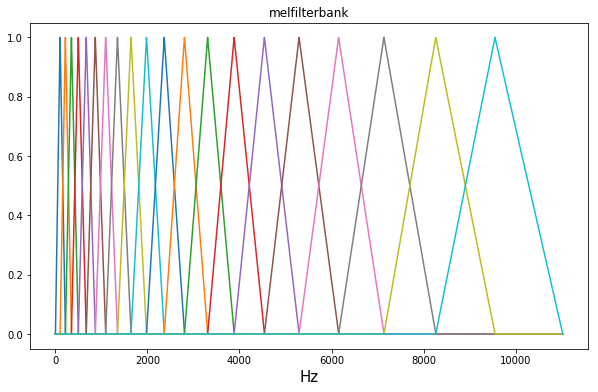

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(filterbank)):
    ax.plot(np.arange(0, nfft/2)*df, filterbank[i])
ax.set_title('melfilterbank')
ax.set_xlabel('Hz', fontsize=15)

上図が20個のメルフィルタバンクです。  
どういった意味を持つか以下で解説します。  
フィルタバンク1枚の三角形のセンター位置を見ますと、等間隔ではないのがわかると思います。  
この意味は、Hzとmel の関係を表す曲線を見るとよくわかります。  

**フィルタバンクの三角形のセンター位置を図示してみます。**

(0, 3266.3796082625927)

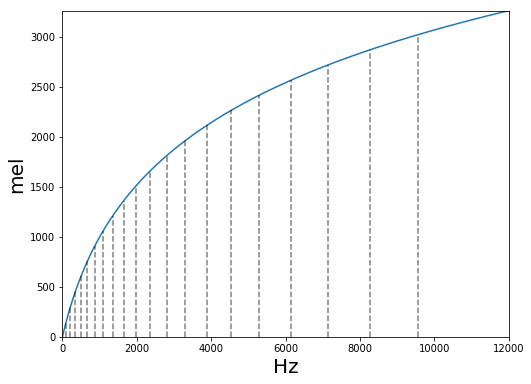

In [17]:
hzs = np.arange(0, 12000, 0.1)
_y = [hz2mel(hz) for hz in hzs]
y_mfb = [hz2mel(hz) for hz in fcenters]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hzs, _y)
for i_hz, hz in enumerate(fcenters):
    ax.axvline(x=hz, ymin=0, ymax=y_mfb[i_hz]/max(_y), linestyle='--', c='black', alpha=0.5)
ax.set_xlabel('Hz', fontsize=20)
ax.set_ylabel('mel', fontsize=20)
ax.set_xlim(0, max(hzs))
ax.set_ylim(0, max(_y))

メルフィルタバンクの周波数を点線で書きました。  
続いて、メルフィルタバンクの周波数位置のmel周波数(縦軸)も図示します。

(0, 3266.3796082625927)

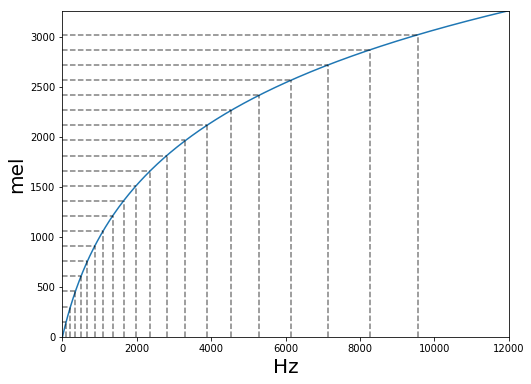

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(hzs, _y)
for i_hz, hz in enumerate(fcenters):
    ax.axvline(x=hz, ymin=0, ymax=y_mfb[i_hz]/max(_y),  linestyle='--', c='black', alpha=0.5)
    ax.axhline(y=y_mfb[i_hz], xmin=0, xmax=hz/max(hzs), linestyle='--', c='black', alpha=0.5)
ax.set_xlabel('Hz', fontsize=20)
ax.set_ylabel('mel', fontsize=20)
ax.set_xlim(0, max(hzs))
ax.set_ylim(0, max(_y))

縦軸の点線に注目してください。  
`等間隔`になっていることがわかると思います。  
メルフィルタバンク1個のセンター周波数は Hz 単位では非等間隔でしたが、melに変換すると、等間隔になります。  
前述しましたが、mel が2倍、3倍になったとき、人間は音の高さが2倍、3倍になったと感じます。  
メルフィルタバンクは、人間の感覚に合うような間隔でセンター位置が変化しているということです。 

---
もう１つの(とはいえ実は上の説明と等価です)大きな意味として、意味のあるデータの密度を調整するような効果もあります。  
たとえば、二つのデータ集合(単位はHz) f1 = {1, 2, 3}、 f2 = {1001, 1002, 1003} を考えます。  
これらのデータ集合は、オーダーが大きく違いますが、変化の仕方は同じです。1 Hz づつ大きくなっているのがわかります。  
これらの変化を人間が聞くとどうなるでしょうか。すでにおわかりかと思いますが、f1は大きな変化として人間は認識し、f2は変化をほとんど感じません。  
故に、人間の聞く感覚の音としては、f2の集合はすべて同様な意味を持つことになります。  
誤解を恐れずに言うと、人間の耳を基準に音を捉えた場合、f1はデータ数3、f2はデータ数1になります。  
つまり、低周波数から高周波数にかけて等間隔のデータを扱った場合、低周波数側は高密度の情報をもち、高周波側はスカスカの情報をもつことになります。  
(あくまでも、人間の感覚という立場に立っての議論だということに注意してください。)

## メルフィルタの適応
- 作成した メルフィルタを順番にかけていきます。

In [19]:
mspec = []
for ch in np.arange(0, numChannels):
    mspec.append(np.log10(sum(spec * filterbank[ch])))
mspec = np.array(mspec)

イメージが湧きやすいようにフィルタを一つだけ書いてみます

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'output')

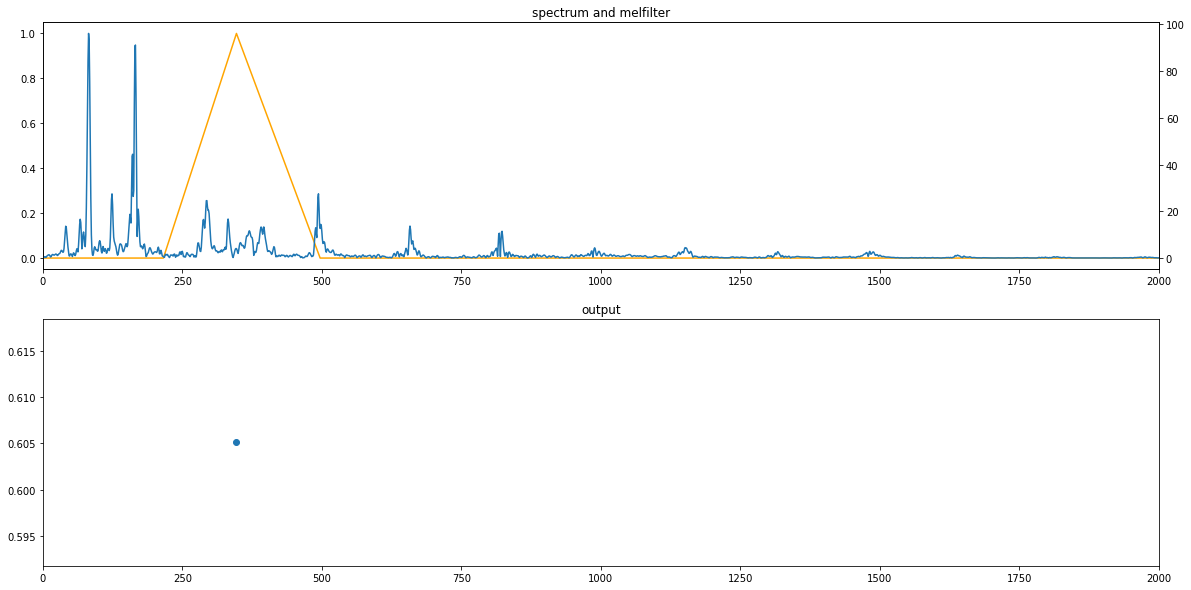

In [20]:
# 2番だけ計算
ch_melf = 2
out = np.log10(sum(spec * filterbank[ch_melf]))

fig, axs = plt.subplots(2,1, figsize=(20, 10))
axs = axs.ravel()
axs[0].plot(np.arange(0, nfft/2)*df, filterbank[ch_melf], c='orange')
axs[0] = axs[0].twinx()
axs[0].plot(spec_abs)
axs[0].set_title('spectrum and melfilter')
axs[0].set_xlim(0, 2000)
axs[1].scatter(fcenters[ch_melf], out)
axs[1].set_xlim(0, 2000)
axs[1].set_title('output')

上の図は、スペクトルとフィルタを表示しています。  
この二つの関数の掛け算をおこない、全て足し合わせた結果が、下の図になっています。  
つまり、フィルタの三角形の部分だけ強調させたイメージです。  
このようにして、フィルタを一枚一枚計算させます。
そして最後に対数を取ります。

**以下で、  
①対数スペクトル  
②メルフィルタバンクを適応したスペクトル  
を図示します**

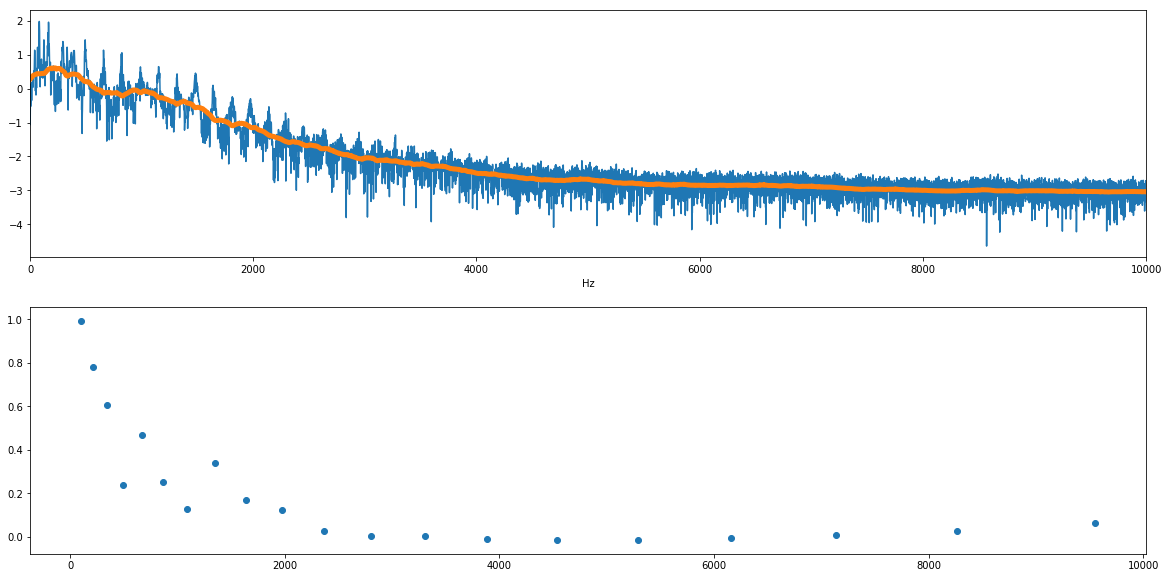

In [21]:
#移動平均
num = 300
b=np.ones(num)/num
spec_ebs_log_ave=np.convolve(spec_ebs_log, b, mode='same')#移動平均

fig, axs = plt.subplots(2,1, figsize=(20, 10))
axs = axs.ravel()
axs[0].plot(fscale, spec_ebs_log)
axs[0].plot(fscale, spec_ebs_log_ave, lw=5)
axs[0].set_xlim(0, 10000)
axs[0].set_xlabel('Hz')
axs[1].scatter(fcenters, mspec)

下の図が、メルフィルタバンクをかけた後に対数をとったデータです。  
上の図の包絡線にある程度似ています。  
そもそも包絡線なら上の図のオレンジ色のようなデータを使えばいいという考えも有りますが、  
前述したように、意味のあるデータの密度が一定でないため、よろしくありません。  
下のグラフのほうは、当たり前ですが、前半は高密度、後半は低密度になっています。  

## MFCC の取得

- 最後のステップです。  
ここでは、包絡線の特徴を取得します。
前にも述べましたが、大まかな形が大事です。  
大まかな形を捉える量を取得するために、上図の下の関数をフーリエ変換し、低次の項を使えばいい事がわかると思います。  
注意としては、周波数空間に対してフーリエ変換を行うので、変換後は時間空間になります。  
フーリエ変換とはいっても、離散コサイン変換を使います。
では、計算していきます。

**離散コサイン変換(dct)**

In [22]:
#ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
ceps = scipy.fftpack.dct(mspec, type=2, norm="ortho", axis=-1)

これがmfccの正体です。  
0から12番目のmfccを使うことが多い印象です。 

In [27]:
ceps.real[:12]

array([ 0.93481606,  1.01555056,  0.54931491,  0.19825048,  0.27236464,
        0.22219626,  0.16034364,  0.03548415,  0.05376798,  0.08270853,
        0.07418838, -0.02086638])

## なぜ離散コサイン変換か？

計算には、スペクトルを使っています。スペクトルは、sinとcosの和で書かれます。  
そのスペクトルは、パワースペクトル(2乗の計算が入る)として計算します。  
そしてパワースペクトルは、sinの2乗とcosの２乗の和になるので、遇関数となります。  
よってそのパワースペクトルのフーリエ変換は遇関数部分のcos だけの成分になります。  